<a href="https://colab.research.google.com/github/aleshark87/data-intensive-project/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Descrizione del problema

*In questo progetto si vuole realizzare un modello in grado di predire la potabilità dell'acqua in base a delle analisi effettuate*

## Importo le librerie necessarie

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from urllib.request import urlretrieve
import random

##Caricamento dei dati


In [61]:
dataset_url = "https://github.com/aleshark87/data-intensive-project/raw/main/water_potability%20(2).csv"
dataset_filename = "water_potability.csv"

if not os.path.exists(dataset_filename):
  urlretrieve(dataset_url, dataset_filename)

dataset = pd.read_csv(dataset_filename, sep=",")
dataset.head(10)  

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


##Descrizione delle feature


###Unità di misura:


*  **NTU**: Nephelometric Turbidity unit
*  **ppm**: Parti per milione
*  **μg/L**: Microgrammi per litro
*  **mg/L**: Milligrammi per litro

###Descrizione:

1. **ph**: Misura del pH dell'acqua.
2. **Hardness**: Misura della durezza dell'acqua. Viene espressa in mg/L.
3. **Solids**: Misura dei materiali disciolti. Viene espressa in ppm.
4. **Chloramines**: Misura delle clorammine in ppm.
5. **Sulfate**: Misura dei solfati in mg/L.
6. **Conductivity**: Conduttività elettrica dell'acqua in μS/cm.
7. **Organic_carbon**: Carbonio organico in ppm.
8. **Trihalomethanes**: Misura dei trialometani in μg/L.
9. **Turbidity**: Misura della torbidità in NTU.
10. **Potability**: Indica se l'acqua è potabile, 1 significa potabile e 0 significa non potabile.



##Analisi generale dei dati

In [62]:
dataset.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Possiamo notare che i dati in nostro possesso sono tutti numerici, e di diversa scala uno dall'altro. Sarà quindi fondamentale procedere allo scaling prima di costruire i modelli. Inoltre, si nota la presenza di valori nulli e di sbilanciamento nella classe **Potability**. 

Vediamo quanti sono i valori nulli all'interno del dataset.

In [63]:
dataset.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Procediamo alla rimozione.

In [64]:
dataset.dropna(inplace=True)
dataset.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

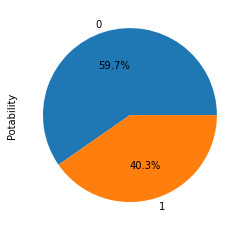

In [65]:
dataset.Potability.value_counts().plot.pie(autopct="%.1f%%");

Da questo grafico a torta possiamo vedere meglio la differenza di distribuzione nelle classi.

In [66]:
#sns.pairplot(dataset, hue="Potability")

Da questi grafici, che confrontano la distribuzione delle feature nel caso di acqua Potabile o meno, notiamo che non ci sono sbilanciamenti importanti.

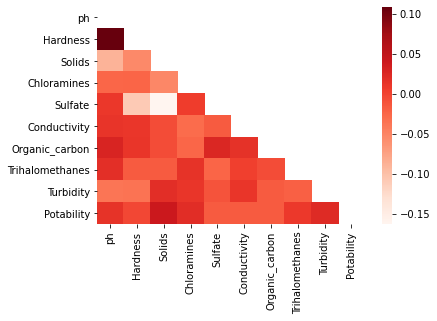

In [67]:
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="Reds");

Anche la heatmap delle correlazioni, che dovrebbe mostrarci correlazioni tra le feature, non ne mostra alcuna rilevante.
Modelli con feature non lineari dovrebbero performare meglio.

##Preparazione dei dati

##Preparazione del modello

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Split in training e validation

In [69]:
X = dataset.drop(columns="Potability")
y = dataset["Potability"]

In [70]:
X_train, X_val, y_train, y_val = train_test_split(
    X,y,
    test_size = 1/3,
    random_state = 42
)

**Perceptron non standardizzato**

In [71]:
not_std_model = Pipeline([
                  ("perc", Perceptron(random_state=42))
])

In [72]:
not_std_model.fit(X_train, y_train)
print("R-squared coefficient:") 
not_std_model.score(X_val, y_val)

R-squared coefficient:


0.6005961251862891

# Bilanciamento classi


In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [74]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

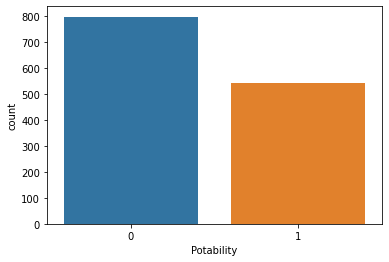

In [75]:
sns.countplot(x=y_train)

Faremo un under-sample della maggioranza e un over-sample della minoranza.
Qui l'under-sample.

In [76]:
rus = RandomUnderSampler(sampling_strategy=0.75)
X_train,y_train = rus.fit_resample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


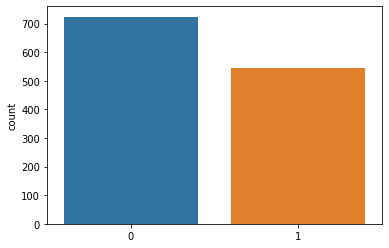

In [77]:
sns.countplot(x=y_train)

Over-sample della minoranza tramite SMOTE.



In [78]:
smote = SMOTE(sampling_strategy='minority')
X_train,y_train = smote.fit_resample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


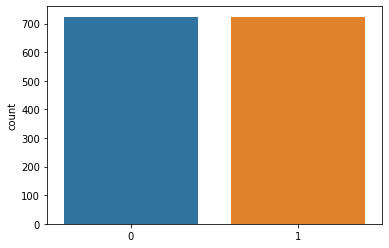

In [79]:
sns.countplot(x=y_train)

# **Modellazione**

In [80]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Creiamo dei dizionari per memorizzare informazioni sui modelli

In [81]:
scores = {}
f1_scores = {}
precision = {}
recall = {}
models = []
confusion_m = {}
mse = {}

**Perceptron**

In [82]:
models.append("Perceptron")

model = Pipeline([
    ("scaler", StandardScaler()),
    ("perc", Perceptron(random_state=42))
])

param = {
    "scaler": [StandardScaler()],
    "perc__penalty": ["l2", "l1"],
    "perc__alpha": np.logspace(-4, 0, 5),
    "perc__fit_intercept": [False, True]
}

In [83]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

In [84]:
perc_gv = GridSearchCV(model, param, cv=skf, n_jobs=-1)
perc_gv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('perc',
                                        Perceptron(alpha=0.0001,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   eta0=1.0, fit_intercept=True,
                                                   max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None, penalty=None,...
                                   

In [85]:
print("Punteggio migliore: {score}".format(score=perc_gv.score(X_val, y_val)));
print("F1 score: {score}".format(score=f1_score(y_val, perc_gv.predict(X_val), average="binary")));
print("Precision score: {score}".format(score=precision_score(y_val, perc_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, perc_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=perc_gv.best_params_))

modelName = models[len(models)-1]
scores[modelName] = perc_gv.score(X_val, y_val);
f1_scores[modelName] = f1_score(y_val, perc_gv.predict(X_val), average="binary")
precision[modelName] = precision_score(y_val, perc_gv.predict(X_val))
recall[modelName] = recall_score(y_val, perc_gv.predict(X_val))

Punteggio migliore: 0.5052160953800298
F1 score: 0.4391891891891892
Precision score: 0.4012345679012346
Recall score: 0.48507462686567165
Parametri migliori: {'perc__alpha': 0.1, 'perc__fit_intercept': False, 'perc__penalty': 'l2', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [86]:
index = ["Not potable", "Potable"]
classes = ["Not potable[P]", "Potable[P]"]
confusion_m[modelName] = pd.DataFrame(confusion_matrix(y_val, perc_gv.predict(X_val)), columns=classes, index = index)
print(confusion_m[modelName])
mse[modelName] = mean_squared_error(y_val, perc_gv.predict(X_val))

             Not potable[P]  Potable[P]
Not potable             209         194
Potable                 138         130


**Regressione Logistica**

In [87]:
models.append("Logistic Regression")

log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(solver='saga', random_state=42))
])

log_grid = {
    "scaler": [StandardScaler()],
    "log_reg__penalty": ["l2", "l1"],
    "log_reg__C": np.logspace(-3, 3, 10),
    "log_reg__fit_intercept": [False, True]
}

In [88]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)
log_gv = GridSearchCV(log_model, log_grid, cv=skf, n_jobs=-1)
log_gv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                  

In [89]:
print("Punteggio migliore: {score}".format(score=log_gv.score(X_val, y_val)));
print("F1 score: {score}".format(score=f1_score(y_val, log_gv.predict(X_val), average="binary")));
print("Precision score: {score}".format(score=precision_score(y_val, log_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, log_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=log_gv.best_params_))

modelName = models[len(models)-1]
scores[modelName] = log_gv.score(X_val, y_val);
f1_scores[modelName] = f1_score(y_val, log_gv.predict(X_val), average="binary")
precision[modelName] = precision_score(y_val, log_gv.predict(X_val))
recall[modelName] = recall_score(y_val, log_gv.predict(X_val))

Punteggio migliore: 0.46795827123695977
F1 score: 0.4157119476268412
Precision score: 0.37026239067055394
Recall score: 0.47388059701492535
Parametri migliori: {'log_reg__C': 0.46415888336127775, 'log_reg__fit_intercept': False, 'log_reg__penalty': 'l1', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [90]:
index = ["Not potable", "Potable"]
classes = ["Not potable[P]", "Potable[P]"]
confusion_m[modelName] = pd.DataFrame(confusion_matrix(y_val, log_gv.predict(X_val)), columns=classes, index = index)
print(confusion_m[modelName])
mse[modelName] = mean_squared_error(y_val, log_gv.predict(X_val))

             Not potable[P]  Potable[P]
Not potable             187         216
Potable                 141         127


**SVC**

In [91]:
models.append("Support Vector Machines")

svc_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

param_svc = {
    'scaler': [StandardScaler()],
    'svc__kernel': ['linear'],
    'svc__kernel': ['rbf'],
    "svc__C": np.linspace(0.5, 5, 10)
}

In [92]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)
svc_gv = GridSearchCV(svc_model, param_svc, cv=skf)
svc_gv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            pr...lity=False, random_state=42,
                                            shr

In [93]:
print("Punteggio migliore: {score}".format(score=svc_gv.score(X_val, y_val)));
print("F1 score: {score}".format(score=f1_score(y_val, svc_gv.predict(X_val), average="binary")));
print("Precision score: {score}".format(score=precision_score(y_val, svc_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, svc_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=svc_gv.best_params_))

modelName = models[len(models)-1]
scores[modelName] = svc_gv.score(X_val, y_val);
f1_scores[modelName] = f1_score(y_val, svc_gv.predict(X_val), average="binary")
precision[modelName] = precision_score(y_val, svc_gv.predict(X_val))
recall[modelName] = recall_score(y_val, svc_gv.predict(X_val))

Punteggio migliore: 0.6363636363636364
F1 score: 0.5658362989323844
Precision score: 0.5408163265306123
Recall score: 0.5932835820895522
Parametri migliori: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'svc__C': 1.0, 'svc__kernel': 'rbf'}


In [94]:
index = ["Not potable", "Potable"]
classes = ["Not potable[P]", "Potable[P]"]
confusion_m[modelName] = pd.DataFrame(confusion_matrix(y_val, svc_gv.predict(X_val)), columns=classes, index = index)
print(confusion_m[modelName])
mse[modelName] = mean_squared_error(y_val, svc_gv.predict(X_val))

             Not potable[P]  Potable[P]
Not potable             268         135
Potable                 109         159


**Decision tree**

In [95]:
models.append("Decision Tree")
num_features = X.columns.size

tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

tree_grid = {'scaler': [StandardScaler()],
             'tree__criterion': ['gini', 'entropy'],
             'tree__max_features': range(5, num_features)}

In [96]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)
tree_gv = GridSearchCV(tree_model, tree_grid, cv=skf, n_jobs=-1)
tree_gv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('tree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                  

In [97]:
print("Punteggio migliore: {score}".format(score=tree_gv.score(X_val, y_val)));
print("F1 score: {score}".format(score=f1_score(y_val, tree_gv.predict(X_val), average="binary")));
print("Precision score: {score}".format(score=precision_score(y_val, tree_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, tree_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=tree_gv.best_params_))

modelName = models[len(models)-1]
scores[modelName] = tree_gv.score(X_val, y_val);
f1_scores[modelName] = f1_score(y_val, tree_gv.predict(X_val), average="binary")
precision[modelName] = precision_score(y_val, tree_gv.predict(X_val))
recall[modelName] = recall_score(y_val, tree_gv.predict(X_val))

Punteggio migliore: 0.5767511177347243
F1 score: 0.5103448275862068
Precision score: 0.47435897435897434
Recall score: 0.5522388059701493
Parametri migliori: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'tree__criterion': 'gini', 'tree__max_features': 5}


In [98]:
confusion_m[modelName] = pd.DataFrame(confusion_matrix(y_val, tree_gv.predict(X_val)), columns=classes, index = index)
print(confusion_m[modelName])
mse[modelName] = mean_squared_error(y_val, tree_gv.predict(X_val))

             Not potable[P]  Potable[P]
Not potable             239         164
Potable                 120         148


**XGBOOST**

In [99]:
from xgboost import XGBClassifier
train_data = pd.DataFrame(X_train, columns=['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'])

In [100]:
models.append("XG Boost")

xgb_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(nthread=8, objective='binary:logistic', random_state=42))
])

parameters = {
    'xgb__max_depth': [13, 14],
    'xgb__grow_policy': ["lossguide", "depthwise"]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(xgb_model, parameters, cv=skf)

gs.fit(train_data, y_train)
y_pred = gs.predict(X_val)

In [101]:
print("Punteggio migliore: {score}".format(score=gs.score(X_val, y_val)));
print("Precision score: {score}".format(score=precision_score(y_val, y_pred)))
print("Recall score: {score}".format(score=recall_score(y_val, y_pred)))
print("Parametri migliori: {params}".format(params=gs.best_params_))

modelName = models[len(models)-1]
scores[modelName] = gs.score(X_val, y_val)
f1_scores[modelName] = f1_score(y_val, y_pred, average="binary")
precision[modelName] = precision_score(y_val, y_pred)
recall[modelName] = recall_score(y_val, y_pred)

Punteggio migliore: 0.6348733233979136
Precision score: 0.5409252669039146
Recall score: 0.5671641791044776
Parametri migliori: {'xgb__grow_policy': 'lossguide', 'xgb__max_depth': 14}


In [102]:
confusion_m[modelName] = pd.DataFrame(confusion_matrix(y_val, y_pred), index=index, columns=classes)
print(confusion_m[modelName])
mse[modelName] = mean_squared_error(y_val, y_pred)

             Not potable[P]  Potable[P]
Not potable             274         129
Potable                 116         152


**Valutazione dei modelli utilizzati**

In [103]:
pd.DataFrame.from_dict(scores, orient="index", columns=["R^2 score"])

,R^2 score
Perceptron,0.505216
Logistic Regression,0.467958
Support Vector Machines,0.636364
Decision Tree,0.576751
XG Boost,0.634873


In [104]:
pd.DataFrame.from_dict(f1_scores, orient="index", columns=["F1 score"])

,F1 score
Perceptron,0.439189
Logistic Regression,0.415712
Support Vector Machines,0.565836
Decision Tree,0.510345
XG Boost,0.553734


In [105]:
pd.DataFrame.from_dict(recall, orient="index", columns=["Recall score"])

,Recall score
Perceptron,0.485075
Logistic Regression,0.473881
Support Vector Machines,0.593284
Decision Tree,0.552239
XG Boost,0.567164


In [106]:
pd.DataFrame.from_dict(precision, orient="index", columns=["Precision score"])

,Precision score
Perceptron,0.401235
Logistic Regression,0.370262
Support Vector Machines,0.540816
Decision Tree,0.474359
XG Boost,0.540925


In [107]:
for i in range(len(models)):
  print(models[i])
  print(confusion_m[models[i]])
  print('\n')

Perceptron
             Not potable[P]  Potable[P]
Not potable             209         194
Potable                 138         130


Logistic Regression
             Not potable[P]  Potable[P]
Not potable             187         216
Potable                 141         127


Support Vector Machines
             Not potable[P]  Potable[P]
Not potable             268         135
Potable                 109         159


Decision Tree
             Not potable[P]  Potable[P]
Not potable             239         164
Potable                 120         148


XG Boost
             Not potable[P]  Potable[P]
Not potable             274         129
Potable                 116         152




**Confronto modelli con intervallo di confidenza**

Quanto sono affidabili i modelli? Calcoliamo il valore di accuratezza in un intervallo di confidenza al 95%

In [108]:
def accuracy(confusion_m):
  return np.diag(confusion_m).sum() / confusion_m.sum().sum()

In [109]:
def confidence_interval(accuracy, N, Z):
  den = (2*(N+Z**2))
  variance = (Z*np.sqrt(Z**2+4*N*accuracy-4*N*accuracy**2)) / den
  a = (2*N*accuracy+Z**2) / den
  inf = a - variance
  sup = a + variance
  return np.round((inf, sup), 4)

In [110]:
def confidence_interval_between_models99(mse1, mse2):
  d = np.abs(mse1 - mse2)
  variance = (mse1 * (1 - mse1)) / len(X_val) + (mse2 * (1 - mse2)) / len(X_val)
  d_min = d - 2.58 * np.sqrt(variance)
  d_max = d + 2.58 * np.sqrt(variance)
  return np.round((d_min, d_max), 4)

In [111]:
#Intervallo di confidenza al 95%
Z = 1.96

pd.DataFrame([confidence_interval(accuracy(confusion_m[models[i]]), len(X_val), Z)  for i in range(5)],
              index=models,
              columns=["inf", "sup"])

,inf,sup
Perceptron,0.4675,0.5429
Logistic Regression,0.4305,0.5058
Support Vector Machines,0.5993,0.6719
Decision Tree,0.5390,0.6136
XG Boost,0.5978,0.6704


In [112]:
for i in range(len(models)):
  for k in range(i+1, len(models)):
    print(models[i] + " vs " + models[k])
    print(confidence_interval_between_models99(mse[models[i]], mse[models[k]]))

Perceptron vs Logistic Regression
[-0.0331  0.1076]
Perceptron vs Support Vector Machines
[0.062  0.2003]
Perceptron vs Decision Tree
[0.0015 0.1415]
Perceptron vs XG Boost
[0.0605 0.1988]
Logistic Regression vs Support Vector Machines
[0.0994 0.2374]
Logistic Regression vs Decision Tree
[0.0389 0.1787]
Logistic Regression vs XG Boost
[0.0979 0.236 ]
Support Vector Machines vs Decision Tree
[-0.0091  0.1283]
Support Vector Machines vs XG Boost
[-0.0663  0.0693]
Decision Tree vs XG Boost
[-0.0106  0.1268]


I modelli che performano meglio non presentano differenze significative.

**Confronto con un modello casuale**

In [113]:
from sklearn.dummy import DummyClassifier

In [114]:
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='uniform')

In [115]:
y_pred = random.predict(X_val)
mse["Random"] = mean_squared_error(y_val, y_pred)

In [116]:
for i in range(len(models)):
  print(models[i] + " vs Random")
  print(confidence_interval_between_models99(mse[models[i]], mse["Random"]))

Perceptron vs Random
[-0.0674  0.0734]
Logistic Regression vs Random
[-0.0361  0.1046]
Support Vector Machines vs Random
[0.065  0.2032]
Decision Tree vs Random
[0.0045 0.1445]
XG Boost vs Random
[0.0635 0.2018]


I modelli basati su Perceptron e Logistic Regression non sono statisticamente migliori rispetto a quello Random.
Tuttavia, i modelli che hanno mostrato score più alti già nelle precedenti analisi performano in modo significativo rispetto al modello casuale.